<a href="https://colab.research.google.com/github/Adityaaaaaaaaaaaaaaa/python_ml_training_hpc/blob/main/HPC_sem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset link:** < [Taxi](https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data/data) >




# Slave Check

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Lazy mode

Uplaoding dataset via kaggle API

Step 1 - Our Slave

In [ ]:
!nvidia-smi

Thu Sep 11 17:05:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Step 2 - Upload Kaggle API Key

Use the kaggle.json from Kaggle account, upload it here:

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"user2025hpc","key":"33bc216d7c30ca7f79f2b9bd3c6269f6"}'}

Step 3: Configure Kaggle API

Move uploaded API key into the correct folder:

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Step 4: Download the NYC Yellow Taxi Dataset

Use the Kaggle API to download the dataset zip:

In [ ]:
!kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data

Dataset URL: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data
License(s): U.S. Government Works
 98% 1.75G/1.78G [00:16<00:00, 90.7MB/s]
100% 1.78G/1.78G [00:16<00:00, 117MB/s] 


Step 5: Extract the Dataset

Unzip downloaded file into a folder called taxi_data:

In [ ]:
!unzip nyc-yellow-taxi-trip-data.zip -d taxi_data

Archive:  nyc-yellow-taxi-trip-data.zip
  inflating: taxi_data/yellow_tripdata_2015-01.csv  
  inflating: taxi_data/yellow_tripdata_2016-01.csv  
  inflating: taxi_data/yellow_tripdata_2016-02.csv  
  inflating: taxi_data/yellow_tripdata_2016-03.csv  


List the files:

In [ ]:
import os
os.listdir("taxi_data")[:10]   # show first 10 files

['yellow_tripdata_2016-01.csv',
 'yellow_tripdata_2015-01.csv',
 'yellow_tripdata_2016-03.csv',
 'yellow_tripdata_2016-02.csv']

# Google Drive mode

NYC Yellow Taxi Trip Data Analysis

Step 1: Mount Google Drive
We mount Google Drive so that we can directly access the taxi dataset stored in the `/MyDrive/taxi` folder.  
This way, the data is persisted and we do not need to re-upload every time we open Colab.

In [ ]:
# =====================================
# MOUNT DRIVE & CHECK ORIGINAL FILES
# =====================================
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Path to taxi folder
data_folder = "/content/drive/MyDrive/taxi"

# Original 4 files
taxi_files = [
    os.path.join(data_folder, "yellow_tripdata_2015-01.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-01.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-02.csv"),
    os.path.join(data_folder, "yellow_tripdata_2016-03.csv"),
]

print("Original files:")
print("+--------------------------------------------------+")
for f in taxi_files:
    if os.path.exists(f):
        size = os.path.getsize(f) / (1024**2)
        print(f"✔ {os.path.basename(f)} ({size:.2f} MB)")
    else:
        print(f"⚠ Missing: {f}")
print("+--------------------------------------------------+")

Mounted at /content/drive
Original files:
+--------------------------------------------------+
✔ yellow_tripdata_2015-01.csv (1893.96 MB)
✔ yellow_tripdata_2016-01.csv (1629.52 MB)
✔ yellow_tripdata_2016-02.csv (1700.93 MB)
✔ yellow_tripdata_2016-03.csv (1825.97 MB)
+--------------------------------------------------+


Merge into `taxi.csv`

In [ ]:
# =====================================
# MERGE FILES INTO taxi.csv
# =====================================
combined_file = os.path.join(data_folder, "taxi.csv")

if not os.path.exists(combined_file):
    print("Merging 4 files into taxi.csv ... this took 18 mins to make.")

    header_written = False
    with open(combined_file, "w") as fout:
        for f in taxi_files:
            for chunk in pd.read_csv(f, chunksize=500000):
                chunk.to_csv(fout, index=False, header=not header_written, mode="a")
                header_written = True
    print("✔ taxi.csv created successfully.")
else:
    print("✔ taxi.csv already exists, skipping merge.")

Merging 4 files into taxi.csv ... this may take several minutes.
✔ taxi.csv created successfully.


# Always Run This Block **first** in Every Session

In [ ]:
# =====================================
# LOAD taxi.csv (EVERY SESSION, RANDOM SAMPLE) - 5 min to run
# =====================================
import pandas as pd
import os
import numpy as np
from google.colab import drive

# Mount Drive (safe every session)
drive.mount('/content/drive')

# Paths
data_folder = "/content/drive/MyDrive/taxi"
combined_file = os.path.join(data_folder, "taxi.csv")

# Count total rows in taxi.csv (excluding header)
with open(combined_file, "r") as f:
    total_rows = sum(1 for _ in f) - 1

print(f"✔ taxi.csv found with {total_rows:,} rows")

# Sample size
sample_size = 100_000   # Set to 10_000_000 or 15_000_000 if memory allows
# set 100k for ML Training

# Pick random rows to load
skip = sorted(
    np.random.choice(
        np.arange(1, total_rows + 1),  # skip these row indices
        size=(total_rows - sample_size),
        replace=False
    )
)

df_sample = pd.read_csv(combined_file, skiprows=skip, low_memory=False)

print(f"✔ Random sample loaded: {len(df_sample):,} rows")
print("Columns available:", df_sample.columns.tolist()) #47,248,845 rows total


Mounted at /content/drive
✔ taxi.csv found with 47,248,845 rows
✔ Random sample loaded: 100,000 rows
Columns available: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


# Pandas

101 - Setup (Code)

In [ ]:
# =====================================
# SETUP PANDAS FOLDER
# =====================================
pandas_folder = os.path.join(data_folder, "pandas")
os.makedirs(pandas_folder, exist_ok=True)

print("✔ Pandas folder ready at:", pandas_folder)

✔ Pandas folder ready at: /content/drive/MyDrive/taxi/pandas


In [ ]:
# =====================================
# P1 – BASIC INSPECTION
# =====================================

print("\nFirst 5 rows:")
print(df_sample.head())

print("\nLast 5 rows:")
print(df_sample.tail())

print("\nDataset shape (rows, columns):", df_sample.shape)

print("\nAvailable columns:")
print(df_sample.columns.tolist())

print("\nData types:")
print(df_sample.dtypes)

print("\nGeneral info:")
print(df_sample.info())


First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
2         1  2015-01-10 20:33:41   2015-01-10 20:35:23                1   
3         1  2015-01-10 20:33:41   2015-01-10 21:03:04                1   
4         2  2015-01-15 19:05:41   2015-01-15 19:10:22                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1          18.20        -73.783043        40.644356           2   
2           0.30        -74.008362        40.704376           1   
3           3.10        -73.973946        40.760448           1   
4           0.89        -73.994957        40.745079           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.75061

In [ ]:
# =====================================
# P2 – DESCRIPTIVE STATISTICS
# =====================================

# 1. Summary statistics
print("\nSummary Statistics:")
print(df_sample.describe(include="all").transpose())

# 2. Missing values
print("\nMissing values per column:")
print(df_sample.isnull().sum())

# 3. Value counts for categorical columns
print("\nVendorID distribution:")
print(df_sample["VendorID"].value_counts())

print("\nPayment type distribution:")
print(df_sample["payment_type"].value_counts())

# 4. Numerical aggregates
print("\nMean trip distance:", df_sample["trip_distance"].mean())
print("Median trip distance:", df_sample["trip_distance"].median())
print("Std dev of fare_amount:", df_sample["fare_amount"].std())

# 5. Example of safe aggregation on full file with chunksize
chunk_iter = pd.read_csv(combined_file, chunksize=500000, usecols=["trip_distance"])
total_sum = 0
total_count = 0
for chunk in chunk_iter:
    total_sum += chunk["trip_distance"].sum()
    total_count += chunk["trip_distance"].count()
mean_distance_full = total_sum / total_count
print("\n[Full taxi.csv computed with chunksize] Mean trip distance:", mean_distance_full)


Summary Statistics:
                           count   unique                  top     freq  \
VendorID               5000000.0      NaN                  NaN      NaN   
tpep_pickup_datetime     5000000  3799101  2015-01-05 09:39:49       10   
tpep_dropoff_datetime    5000000  3801112  2015-01-02 00:00:00       20   
passenger_count        5000000.0      NaN                  NaN      NaN   
trip_distance          5000000.0      NaN                  NaN      NaN   
pickup_longitude       5000000.0      NaN                  NaN      NaN   
pickup_latitude        5000000.0      NaN                  NaN      NaN   
RateCodeID             5000000.0      NaN                  NaN      NaN   
store_and_fwd_flag       5000000        2                    N  4967323   
dropoff_longitude      5000000.0      NaN                  NaN      NaN   
dropoff_latitude       5000000.0      NaN                  NaN      NaN   
payment_type           5000000.0      NaN                  NaN      NaN   
fare

In [ ]:
# =====================================
# P3 – DATA CLEANING
# =====================================
p3_folder = os.path.join(pandas_folder, "p3")
os.makedirs(p3_folder, exist_ok=True)

# 1. Missing values
print("\nMissing values per column:")
print(df_sample.isnull().sum())

# Drop rows with missing values
df_dropna = df_sample.dropna()
print(f"\nRows after dropna: {len(df_dropna)} / {len(df_sample)}")

# Fill missing numeric values with 0
df_fillna = df_sample.fillna(0)

# 2. Remove duplicates
df_nodup = df_sample.drop_duplicates(subset=["passenger_count", "trip_distance"])
print(f"\nRows after dropping duplicates: {len(df_nodup)} / {len(df_sample)}")

# 3. Replace values for payment_type
df_replace = df_sample.copy()
df_replace["payment_type"] = df_replace["payment_type"].replace({
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
})
print("\nPayment type value counts after replace:")
print(df_replace["payment_type"].value_counts())

# 4. Save cleaned sample
output_file = os.path.join(p3_folder, "p3_cleaned_sample.csv")
df_replace.to_csv(output_file, index=False)
print(f"\n✔ Cleaned sample saved to: {output_file}")



Missing values per column:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    1
total_amount             0
dtype: int64

Rows after dropna: 4999999 / 5000000

Rows after dropping duplicates: 15960 / 5000000

Payment type value counts after replace:
payment_type
Credit Card    3267272
Cash           1709533
No Charge        17356
Dispute           5839
Name: count, dtype: int64

✔ Cleaned sample saved to: /content/drive/MyDrive/taxi/pandas/p3/p3_cleaned_sample.csv


In [ ]:
# =====================================
# P4 – SELECTION & FILTERING
# =====================================

# 1. Selecting columns
print("\nSingle column (trip_distance):")
print(df_sample["trip_distance"].head())

print("\nMultiple columns (passenger_count, fare_amount):")
print(df_sample[["passenger_count", "fare_amount"]].head())

# 2. Selecting rows
print("\nFirst row with iloc[0]:")
print(df_sample.iloc[0])

print("\nRow with index 100 using loc:")
print(df_sample.loc[100])

# 3. Boolean filtering
print("\nTrips with passenger_count > 2:")
print(df_sample[df_sample["passenger_count"] > 2].head())

print("\nTrips with fare_amount > 50:")
print(df_sample[df_sample["fare_amount"] > 50].head())

# 4. Multiple conditions
print("\n(passenger_count > 2) AND (fare_amount > 50):")
print(df_sample[(df_sample["passenger_count"] > 2) & (df_sample["fare_amount"] > 50)].head())

print("\n(fare_amount < 5) OR (fare_amount > 100):")
print(df_sample[(df_sample["fare_amount"] < 5) | (df_sample["fare_amount"] > 100)].head())

# 5. Using query()
print("\nUsing query() for passenger_count == 1 and trip_distance > 5:")
print(df_sample.query("passenger_count == 1 and trip_distance > 5").head())



Single column (trip_distance):
0     1.59
1    18.20
2     0.30
3     3.10
4     0.89
Name: trip_distance, dtype: float64

Multiple columns (passenger_count, fare_amount):
   passenger_count  fare_amount
0                1         12.0
1                3         52.0
2                1          3.0
3                1         19.0
4                1          5.5

First row with iloc[0]:
VendorID                                   2
tpep_pickup_datetime     2015-01-15 19:05:39
tpep_dropoff_datetime    2015-01-15 19:23:42
passenger_count                            1
trip_distance                           1.59
pickup_longitude                  -73.993896
pickup_latitude                    40.750111
RateCodeID                                 1
store_and_fwd_flag                         N
dropoff_longitude                 -73.974785
dropoff_latitude                   40.750618
payment_type                               1
fare_amount                             12.0
extra                    

In [ ]:
# =====================================
# P5 – SORTING & INDEXING
# =====================================

# 1. Sorting by column values
print("\nSorting by fare_amount (ascending):")
print(df_sample.sort_values(by="fare_amount").head())

print("\nSorting by fare_amount (descending):")
print(df_sample.sort_values(by="fare_amount", ascending=False).head())

print("\nSorting by passenger_count then fare_amount:")
print(df_sample.sort_values(by=["passenger_count", "fare_amount"], ascending=[True, False]).head())

# 2. Sorting by row index
print("\nSorting by index (descending):")
print(df_sample.sort_index(ascending=False).head())

# 3. Changing the index
df_indexed = df_sample.set_index("tpep_pickup_datetime")
print("\nAfter setting pickup datetime as index:")
print(df_indexed.head())

# 4. Resetting the index
df_reset = df_indexed.reset_index()
print("\nAfter resetting the index:")
print(df_reset.head())


Sorting by fare_amount (ascending):
         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
109331          2  2015-01-11 03:56:15   2015-01-11 03:56:17                1   
2881053         2  2016-02-12 12:57:52   2016-02-12 13:00:29                3   
3991283         2  2016-03-11 03:48:06   2016-03-11 03:48:11                1   
1884080         2  2016-01-17 03:01:48   2016-01-17 03:05:25                2   
2766828         2  2016-02-07 01:53:43   2016-02-07 01:53:55                1   

         trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
109331            0.00          0.000000         0.000000           5   
2881053           0.00        -73.862381        40.768848           5   
3991283           0.10          0.000000         0.000000           5   
1884080           0.29        -74.002579        40.739750           5   
2766828           0.00        -73.993767        40.748341           5   

        store_and_fwd_flag  dropoff_l

In [ ]:
# =====================================
# P6 – GROUPBY & AGGREGATIONS
# =====================================

# 1. GroupBy with single aggregation
print("\nAverage fare_amount per passenger_count:")
print(df_sample.groupby("passenger_count")["fare_amount"].mean())

print("\nNumber of trips per VendorID:")
print(df_sample.groupby("VendorID")["VendorID"].count())

# 2. GroupBy with multiple aggregations
print("\nAggregated statistics per payment_type:")
agg_stats = df_sample.groupby("payment_type").agg({
    "fare_amount": ["mean", "median", "max"],
    "trip_distance": ["mean", "max", "min"]
})
print(agg_stats)

# 3. Pivot table
print("\nPivot table: Average fare_amount by payment_type and passenger_count:")
pivot = pd.pivot_table(
    df_sample,
    values="fare_amount",
    index="payment_type",
    columns="passenger_count",
    aggfunc="mean"
)
print(pivot)


Average fare_amount per passenger_count:
passenger_count
0    14.002684
1    12.225174
2    12.916535
3    12.649777
4    12.868628
5    12.457253
6    12.201079
7    39.800000
8    61.300000
9    28.700000
Name: fare_amount, dtype: float64

Number of trips per VendorID:
VendorID
1    2352038
2    2647962
Name: VendorID, dtype: int64

Aggregated statistics per payment_type:
             fare_amount                 trip_distance                 
                    mean median      max          mean         max  min
payment_type                                                           
1              12.905222    9.5   999.98      4.145340   3180000.0  0.0
2              11.341586    8.5  8008.00     22.704935  19072628.8  0.0
3              11.994475    6.0  6400.00      2.868769       254.7  0.0
4              10.823513    7.0   220.00    282.835009   1633973.4  0.0

Pivot table: Average fare_amount by payment_type and passenger_count:
passenger_count          0          1          

In [ ]:
# =====================================
# P7 – APPLY & CUSTOM FUNCTIONS
# =====================================

# 1. Using .apply() on a column
print("\nSquare root of trip_distance (first 5 values):")
print(df_sample["trip_distance"].apply(lambda x: x**0.5).head())

# 2. Using .map() on a column
print("\nPayment_type mapped to text labels (first 5 values):")
payment_map = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}
print(df_sample["payment_type"].map(payment_map).head())

# 3. Using .applymap() on a DataFrame
print("\nApplying rounding (applymap) on first 3 numeric columns:")
print(df_sample[["fare_amount", "tip_amount", "total_amount"]].applymap(lambda x: round(x, 1)).head())

# 4. Creating a custom column with apply
def tip_percentage(row):
    return (row["tip_amount"] / row["fare_amount"] * 100) if row["fare_amount"] > 0 else 0

df_sample["tip_percent"] = df_sample.apply(tip_percentage, axis=1)
print("\nNew column 'tip_percent' created (first 5 rows):")
print(df_sample[["fare_amount", "tip_amount", "tip_percent"]].head())


Square root of trip_distance (first 5 values):
0    1.260952
1    4.266146
2    0.547723
3    1.760682
4    0.943398
Name: trip_distance, dtype: float64

Payment_type mapped to text labels (first 5 values):
0    Credit Card
1           Cash
2           Cash
3    Credit Card
4    Credit Card
Name: payment_type, dtype: object

Applying rounding (applymap) on first 3 numeric columns:


/tmp/ipython-input-4016732105.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_sample[["fare_amount", "tip_amount", "total_amount"]].applymap(lambda x: round(x, 1)).head())


   fare_amount  tip_amount  total_amount
0         12.0         3.2          17.1
1         52.0         0.0          58.1
2          3.0         0.0           4.3
3         19.0         3.0          23.3
4          5.5         1.6           8.9

New column 'tip_percent' created (first 5 rows):
   fare_amount  tip_amount  tip_percent
0         12.0        3.25    27.083333
1         52.0        0.00     0.000000
2          3.0        0.00     0.000000
3         19.0        3.00    15.789474
4          5.5        1.62    29.454545


In [ ]:
# =====================================
# P8 – MERGING & CONCATENATING
# =====================================

# Create two small DataFrames for demonstration
df1 = df_sample[["VendorID", "fare_amount", "tip_amount"]].head(5)
df2 = df_sample[["VendorID", "trip_distance", "payment_type"]].head(5)

print("\nDF1:")
print(df1)

print("\nDF2:")
print(df2)

# 1. Concatenation (vertical)
df_concat_vertical = pd.concat([df1, df1], axis=0)
print("\nConcatenation (vertical stacking):")
print(df_concat_vertical)

# 2. Concatenation (horizontal)
df_concat_horizontal = pd.concat([df1, df2], axis=1)
print("\nConcatenation (horizontal side-by-side):")
print(df_concat_horizontal)

# 3. Merge on common column VendorID
df_merged = pd.merge(df1, df2, on="VendorID")
print("\nMerge on VendorID:")
print(df_merged)


DF1:
   VendorID  fare_amount  tip_amount
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62

DF2:
   VendorID  trip_distance  payment_type
0         2           1.59             1
1         1          18.20             2
2         1           0.30             2
3         1           3.10             1
4         2           0.89             1

Concatenation (vertical stacking):
   VendorID  fare_amount  tip_amount
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62
0         2         12.0        3.25
1         1         52.0        0.00
2         1          3.0        0.00
3         1         19.0        3.00
4         2          5.5        1.62

Concatenation (horizontal side-by-side):
   VendorID  fare_amount  tip_amoun

In [ ]:
# =====================================
# P9 – EXPORTING DATA
# =====================================

p9_folder = os.path.join(pandas_folder, "p9")
os.makedirs(p9_folder, exist_ok=True)

# Use a small sample for export demo
export_sample = df_sample.head(1000)

# 1. Export to CSV
csv_path = os.path.join(p9_folder, "p9_export_sample.csv")
export_sample.to_csv(csv_path, index=False)
print(f"✔ Exported to CSV: {csv_path}")

# 2. Export to Excel
excel_path = os.path.join(p9_folder, "p9_export_sample.xlsx")
export_sample.to_excel(excel_path, index=False)
print(f"✔ Exported to Excel: {excel_path}")

# 3. Export to JSON
json_path = os.path.join(p9_folder, "p9_export_sample.json")
export_sample.to_json(json_path, orient="records", lines=True)
print(f"✔ Exported to JSON: {json_path}")

# 4. Export to Pickle
pickle_path = os.path.join(p9_folder, "p9_export_sample.pkl")
export_sample.to_pickle(pickle_path)
print(f"✔ Exported to Pickle: {pickle_path}")

✔ Exported to CSV: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.csv
✔ Exported to Excel: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.xlsx
✔ Exported to JSON: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.json
✔ Exported to Pickle: /content/drive/MyDrive/taxi/pandas/p9/p9_export_sample.pkl


In [ ]:
# =====================================
# P10 – ADVANCED QUERIES
# =====================================

# 1. Boolean masks (AND, OR, NOT)
print("\nTrips with fare_amount > 50 AND passenger_count > 2:")
print(df_sample[(df_sample["fare_amount"] > 50) & (df_sample["passenger_count"] > 2)].head())

print("\nTrips with fare_amount < 5 OR trip_distance > 20:")
print(df_sample[(df_sample["fare_amount"] < 5) | (df_sample["trip_distance"] > 20)].head())

print("\nTrips NOT paid by cash (payment_type != 2):")
print(df_sample[~(df_sample["payment_type"] == 2)].head())

# 2. Using query()
print("\nUsing query() for trips with passenger_count == 1 and fare_amount between 20 and 40:")
print(df_sample.query("passenger_count == 1 and 20 <= fare_amount <= 40").head())

# 3. Multiple conditions on different columns
print("\nTrips with tip_amount > 5 and total_amount > 50:")
print(df_sample.query("tip_amount > 5 and total_amount > 50").head())

# 4. String matching (check store_and_fwd_flag)
print("\nTrips where store_and_fwd_flag contains 'Y':")
print(df_sample[df_sample["store_and_fwd_flag"].astype(str).str.contains("Y")].head())


Trips with fare_amount > 50 AND passenger_count > 2:
     VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
1           1  2015-01-10 20:33:39   2015-01-10 21:11:35                3   
144         1  2015-01-21 02:01:46   2015-01-21 02:32:14                3   
375         2  2015-01-24 18:38:59   2015-01-24 19:04:00                4   
684         2  2015-01-22 15:12:41   2015-01-22 16:02:28                6   
715         1  2015-01-01 07:02:13   2015-01-01 07:28:51                3   

     trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
1            18.20        -73.783043        40.644356           2   
144          20.00        -73.782219        40.644691           2   
375          16.88        -73.970787        40.754681           2   
684          16.13        -73.974266        40.760067           2   
715          18.10        -73.776894        40.645138           2   

    store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment

In [ ]:
# =====================================
# P11 – HANDLING MISSING DATA
# =====================================

# 1. Count missing values per column
print("Missing values per column:")
print(df_sample.isnull().sum())

# 2. Drop rows with ANY missing values
df_no_na = df_sample.dropna()
print("\nAfter dropna -> Shape:", df_no_na.shape)

# 3. Fill missing values with constant (0 for numeric, 'Unknown' for text)
df_fill_const = df_sample.fillna({
    "passenger_count": 0,
    "fare_amount": 0,
    "tip_amount": 0,
    "total_amount": 0,
    "payment_type": "Unknown",
    "RatecodeID": "Unknown",
    "store_and_fwd_flag": "Unknown"
})
print("\nAfter fillna with constants (first 5 rows of payment_type, total_amount):")
print(df_fill_const[["payment_type", "total_amount"]].head())

# 4. Fill numeric columns with mean
df_fill_mean = df_sample.copy()
for col in ["trip_distance", "fare_amount", "tip_amount", "total_amount"]:
    df_fill_mean[col] = df_fill_mean[col].fillna(df_fill_mean[col].mean())
print("\nAfter fillna with column mean (trip_distance, fare_amount shown):")
print(df_fill_mean[["trip_distance", "fare_amount"]].head())

# 5. Forward fill
df_ffill = df_sample.fillna(method="ffill")
print("\nForward fill (first 5 rows of store_and_fwd_flag):")
print(df_ffill["store_and_fwd_flag"].head(10))

# 6. Backward fill
df_bfill = df_sample.fillna(method="bfill")
print("\nBackward fill (first 5 rows of store_and_fwd_flag):")
print(df_bfill["store_and_fwd_flag"].head(10))

Missing values per column:
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    1
total_amount             0
tip_percent              0
dtype: int64

After dropna -> Shape: (4999999, 20)

After fillna with constants (first 5 rows of payment_type, total_amount):
   payment_type  total_amount
0             1         17.05
1             2         58.13
2             2          4.30
3             1         23.30
4             1          8.92

After fillna with column mean (trip_distance, fare_amount shown):
   trip_distance  fare_amount
0           1.59         12.0


/tmp/ipython-input-1862447859.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df_sample.fillna(method="ffill")



Forward fill (first 5 rows of store_and_fwd_flag):
0    N
1    N
2    N
3    N
4    N
5    N
6    N
7    N
8    N
9    N
Name: store_and_fwd_flag, dtype: object


/tmp/ipython-input-1862447859.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bfill = df_sample.fillna(method="bfill")



Backward fill (first 5 rows of store_and_fwd_flag):
0    N
1    N
2    N
3    N
4    N
5    N
6    N
7    N
8    N
9    N
Name: store_and_fwd_flag, dtype: object


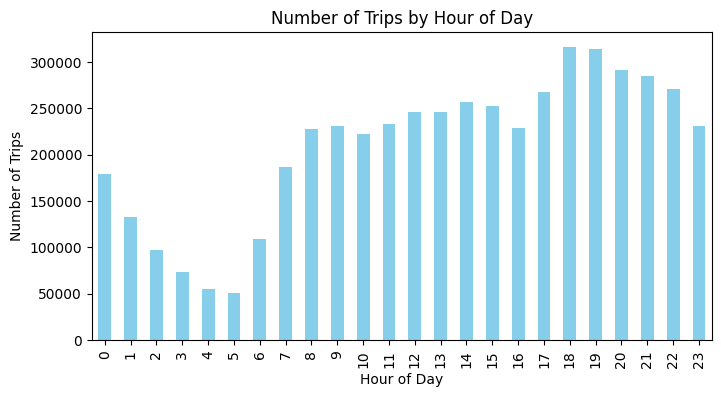

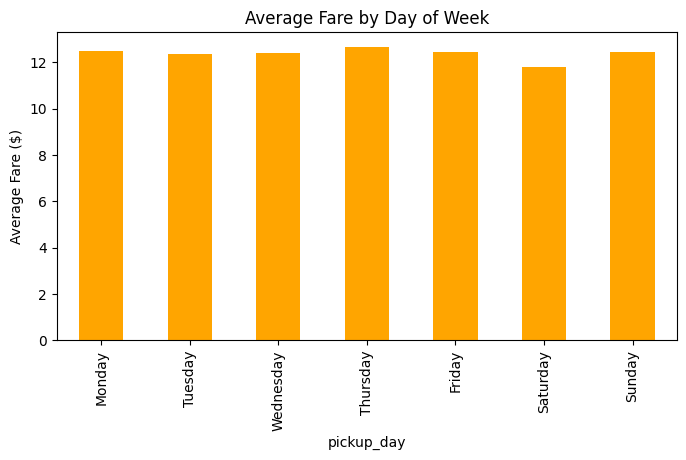

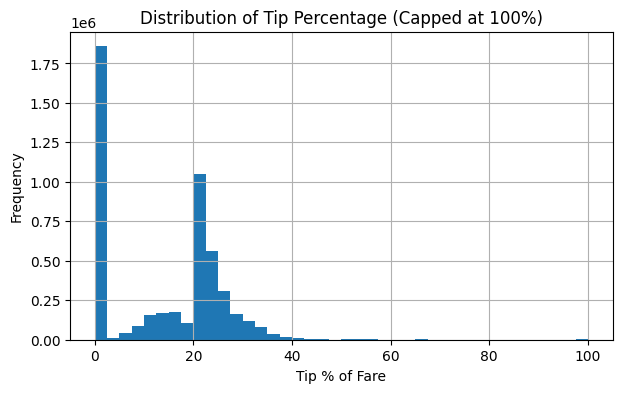

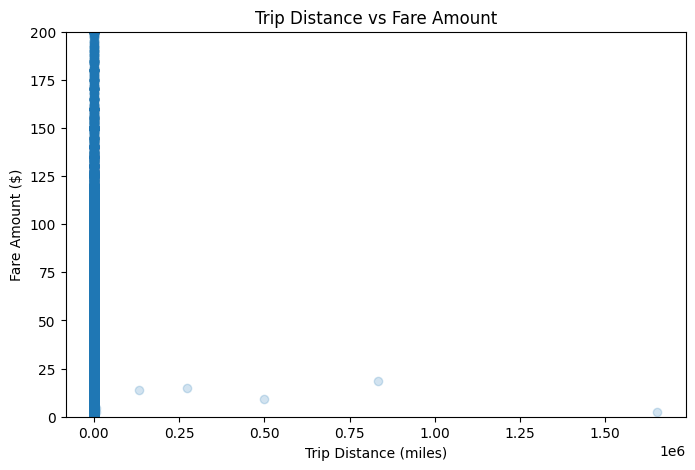

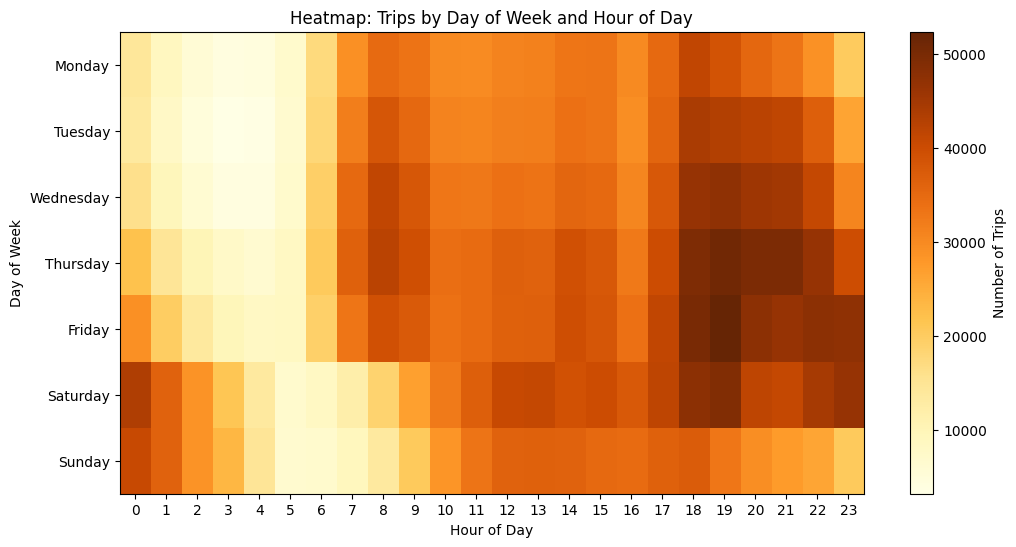

In [ ]:
# =====================================
# P12 – DATA VISUALIZATION (Improved)
# =====================================
import matplotlib.pyplot as plt

# Ensure datetime conversion
df_sample["tpep_pickup_datetime"] = pd.to_datetime(df_sample["tpep_pickup_datetime"], errors="coerce")
df_sample["pickup_hour"] = df_sample["tpep_pickup_datetime"].dt.hour
df_sample["pickup_day"] = df_sample["tpep_pickup_datetime"].dt.day_name()

# 1. Trips per Hour of Day
trips_per_hour = df_sample.groupby("pickup_hour")["VendorID"].count()
plt.figure(figsize=(8,4))
trips_per_hour.plot(kind="bar", color="skyblue")
plt.title("Number of Trips by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# 2. Average Fare by Day of Week
avg_fare_day = df_sample.groupby("pickup_day")["fare_amount"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.figure(figsize=(8,4))
avg_fare_day.plot(kind="bar", color="orange")
plt.title("Average Fare by Day of Week")
plt.ylabel("Average Fare ($)")
plt.show()

# 3. Distribution of Tip % (tip_amount / fare_amount * 100)
df_sample["tip_percent"] = df_sample.apply(
    lambda row: (row["tip_amount"]/row["fare_amount"]*100) if row["fare_amount"]>0 else 0,
    axis=1
)
plt.figure(figsize=(7,4))
df_sample["tip_percent"].clip(0,100).hist(bins=40)
plt.title("Distribution of Tip Percentage (Capped at 100%)")
plt.xlabel("Tip % of Fare")
plt.ylabel("Frequency")
plt.show()

# 4. Scatter plot: Trip Distance vs Fare Amount
plt.figure(figsize=(8,5))
plt.scatter(df_sample["trip_distance"], df_sample["fare_amount"], alpha=0.2)
plt.title("Trip Distance vs Fare Amount")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.ylim(0, 200)   # cap y-axis for readability
plt.show()

# 5. Heatmap: Trips by Day of Week and Hour
import numpy as np

pivot_counts = pd.pivot_table(
    df_sample,
    index="pickup_day",
    columns="pickup_hour",
    values="VendorID",
    aggfunc="count",
    fill_value=0
)

# Reorder days of week
days_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot_counts = pivot_counts.reindex(days_order)

plt.figure(figsize=(12,6))
plt.imshow(pivot_counts, cmap="YlOrBr", aspect="auto")
plt.xticks(range(24), range(24))
plt.yticks(range(len(pivot_counts.index)), pivot_counts.index)
plt.colorbar(label="Number of Trips")
plt.title("Heatmap: Trips by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


Correlation Matrix:
                       VendorID  passenger_count  trip_distance  \
VendorID               1.000000         0.294494      -0.000765   
passenger_count        0.294494         1.000000      -0.000050   
trip_distance         -0.000765        -0.000050       1.000000   
pickup_longitude      -0.061702        -0.020797      -0.000130   
pickup_latitude        0.061756         0.020785       0.000133   
RateCodeID            -0.003503        -0.006413       0.000822   
dropoff_longitude     -0.057112        -0.019044      -0.000148   
dropoff_latitude       0.057116         0.019063       0.000152   
payment_type          -0.015257         0.011726       0.000721   
fare_amount            0.011480         0.009070       0.003322   
extra                 -0.002155         0.000328       0.000022   
mta_tax                0.002369         0.004855      -0.000957   
tip_amount             0.007402        -0.005598       0.001704   
tolls_amount           0.006208         0

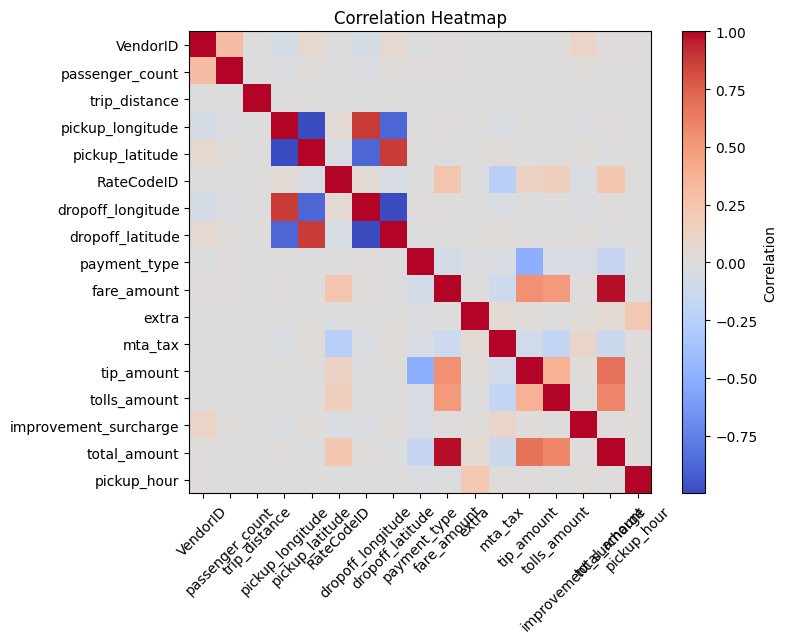

In [ ]:
# =====================================
# P13 – CORRELATION & COVARIANCE
# =====================================

# 1. Correlation matrix
print("\nCorrelation Matrix:")
print(df_sample.corr(numeric_only=True))

# 2. Covariance matrix
print("\nCovariance Matrix:")
print(df_sample.cov(numeric_only=True))

# 3. Heatmap visualization of correlation matrix
plt.figure(figsize=(8,6))
plt.imshow(df_sample.corr(numeric_only=True), cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(df_sample.select_dtypes("number").columns)), df_sample.select_dtypes("number").columns, rotation=45)
plt.yticks(range(len(df_sample.select_dtypes("number").columns)), df_sample.select_dtypes("number").columns)
plt.title("Correlation Heatmap")
plt.show()


Unique pickup dates: 122
Unique pickup hours: [20 19  0 13 14 12 10  9 22 23 16 21  1  5 17  8  2  6 11 18  7 15  3  4]

Daily average fares (first 10 days):
tpep_pickup_datetime
2015-01-01    12.837768
2015-01-02    12.089675
2015-01-03    11.608781
2015-01-04    12.728381
2015-01-05    12.230989
2015-01-06    11.822433
2015-01-07    11.539284
2015-01-08    11.703352
2015-01-09    11.994189
2015-01-10    11.398400
Freq: D, Name: fare_amount, dtype: float64


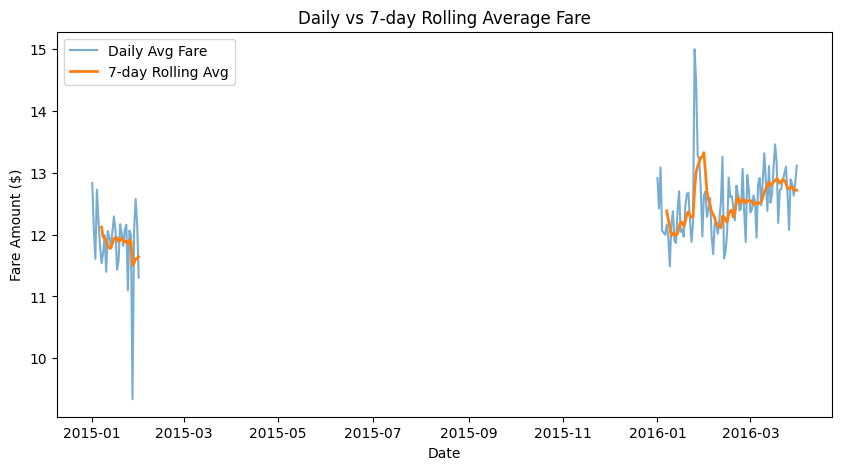

In [ ]:
# =====================================
# P14 – TIME-SERIES HANDLING
# =====================================
import matplotlib.pyplot as plt
import pandas as pd

# 1. Convert to datetime
df_sample["tpep_pickup_datetime"] = pd.to_datetime(df_sample["tpep_pickup_datetime"])
df_sample["tpep_dropoff_datetime"] = pd.to_datetime(df_sample["tpep_dropoff_datetime"])

# 2. Extract date parts
df_sample["pickup_date"] = df_sample["tpep_pickup_datetime"].dt.date
df_sample["pickup_hour"] = df_sample["tpep_pickup_datetime"].dt.hour

print("\nUnique pickup dates:", df_sample["pickup_date"].nunique())
print("Unique pickup hours:", df_sample["pickup_hour"].unique())

# 3. Resample daily average fare
daily_avg = (
    df_sample.set_index("tpep_pickup_datetime")
    .resample("D")["fare_amount"]
    .mean()
)
print("\nDaily average fares (first 10 days):")
print(daily_avg.head(10))

# 4. Rolling mean of fares (7-day window)
rolling_fares = daily_avg.rolling(window=7).mean()
plt.figure(figsize=(10,5))
plt.plot(daily_avg.index, daily_avg.values, label="Daily Avg Fare", alpha=0.6)
plt.plot(rolling_fares.index, rolling_fares.values, label="7-day Rolling Avg", linewidth=2)
plt.title("Daily vs 7-day Rolling Average Fare")
plt.xlabel("Date")
plt.ylabel("Fare Amount ($)")
plt.legend()
plt.show()

In [ ]:
# =====================================
# P15 – ADVANCED TOPICS
# =====================================

# 1. Concatenate multiple samples (simulate combining multiple monthly files)
chunk1 = pd.read_csv(combined_file, nrows=100000)
chunk2 = pd.read_csv(combined_file, skiprows=100000, nrows=100000, header=0)
df_concat = pd.concat([chunk1, chunk2])
print("\nConcatenated DataFrame shape:", df_concat.shape)

# 2. Merge example: join a small lookup table for payment type codes
payment_lookup = pd.DataFrame({
    "payment_type": [1,2,3,4,5,6],
    "payment_label": ["Credit Card","Cash","No Charge","Dispute","Unknown","Voided Trip"]
})
df_merged = pd.merge(df_sample, payment_lookup, on="payment_type", how="left")
print("\nMerge with payment type labels (first 5 rows):")
print(df_merged[["payment_type","payment_label"]].head())

# 3. Pivot table: average fare_amount by passenger_count and VendorID
pivot = pd.pivot_table(
    df_sample,
    values="fare_amount",
    index="passenger_count",
    columns="VendorID",
    aggfunc="mean"
)
print("\nPivot table: average fare_amount by passenger_count & VendorID")
print(pivot)

# 4. GroupBy with custom function (90th percentile tip_amount by passenger_count)
def q90(x):
    return x.quantile(0.9)

tip_stats = df_sample.groupby("passenger_count")["tip_amount"].agg(
    mean="mean", median="median", q90=q90
)
print("\nTip statistics per passenger_count:")
print(tip_stats)


Concatenated DataFrame shape: (200000, 38)

Merge with payment type labels (first 5 rows):
   payment_type payment_label
0             2          Cash
1             1   Credit Card
2             1   Credit Card
3             1   Credit Card
4             1   Credit Card

Pivot table: average fare_amount by passenger_count & VendorID
VendorID                 1          2
passenger_count                      
0                10.636163  24.387465
1                11.945196  12.548954
2                13.514931  12.496434
3                13.279319  12.254442
4                13.769374  12.111618
5                15.606449  12.423086
6                17.308460  12.270622
7                      NaN  39.857000
8                      NaN  56.833333
9                17.000000  65.766667

Tip statistics per passenger_count:
                     mean  median    q90
passenger_count                         
0                1.595300    1.00  3.200
1                1.719735    1.25  3.950
2      

# Dask

In [ ]:
# =====================================
# DASK SETUP
# =====================================
import dask.dataframe as dd

# Setup dask folder
dask_folder = os.path.join(data_folder, "dask")
os.makedirs(dask_folder, exist_ok=True)
print("✔ Dask folder ready at:", dask_folder)

# Load taxi.csv into Dask DataFrame
ddf = dd.read_csv(combined_file, assume_missing=True)

print("✔ taxi.csv loaded into Dask DataFrame")
print("Dask DataFrame:", ddf)


✔ Dask folder ready at: /content/drive/MyDrive/taxi/dask
✔ taxi.csv loaded into Dask DataFrame
Dask DataFrame: Dask DataFrame Structure:
                VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance pickup_longitude pickup_latitude RateCodeID store_and_fwd_flag dropoff_longitude dropoff_latitude payment_type fare_amount    extra  mta_tax tip_amount tolls_amount improvement_surcharge total_amount
npartitions=116                                                                                                                                                                                                                                                                                          
                 float64               string                string         float64       float64          float64         float64    float64             string           float64          float64      float64     float64  float64  float64    float64      float64     

In [ ]:
# =====================================
# d2: BASIC INSPECTION
# =====================================

# 1. Preview first 5 rows
print("\nFirst 5 rows:")
print(ddf.head())

# 2. List of columns
print("\nAvailable columns:")
print(ddf.columns.tolist())

# 3. Data types
print("\nData types:")
print(ddf.dtypes)

# 4. Number of rows and columns
# Dask doesn't have .shape directly -> we compute
row_count = ddf.shape[0].compute()
col_count = ddf.shape[1]
print(f"\nDataset shape: {row_count:,} rows × {col_count} columns")

# 5. Memory usage estimate (using sample)
sample = ddf.head(100000)
memory_bytes = sample.memory_usage(deep=True).sum()
memory_mb = memory_bytes / (1024 * 1024)
memory_gb = memory_bytes / (1024 * 1024 * 1024)

print("\nApproximate memory usage (per 100,000 rows):")
if memory_gb >= 1:
    print(f"{memory_gb:.2f} GB")
else:
    print(f"{memory_mb:.2f} MB")


First 5 rows:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2015-01-15 19:05:39   2015-01-15 19:23:42              1.0   
1       1.0  2015-01-10 20:33:38   2015-01-10 20:53:28              1.0   
2       1.0  2015-01-10 20:33:38   2015-01-10 20:43:41              1.0   
3       1.0  2015-01-10 20:33:39   2015-01-10 20:35:31              1.0   
4       1.0  2015-01-10 20:33:39   2015-01-10 20:52:58              1.0   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111         1.0   
1           3.30        -74.001648        40.724243         1.0   
2           1.80        -73.963341        40.802788         1.0   
3           0.50        -74.009087        40.713818         1.0   
4           3.00        -73.971176        40.762428         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.75061

In [ ]:
# =====================================
# d3: DESCRIPTIVE STATISTICS
# =====================================
# runs for 15 mins, works but do not run

# 1. Summary statistics
print("\nSummary statistics:")
print(ddf.describe().compute())

# 2. Missing values per column
print("\nMissing values per column:")
print(ddf.isnull().sum().compute())

# 3. Value counts for categorical columns
print("\nVendorID value counts:")
print(ddf["VendorID"].value_counts().compute())

print("\nPayment type value counts:")
print(ddf["payment_type"].value_counts().compute())



Summary statistics:
           VendorID  passenger_count  trip_distance  pickup_longitude  \
count  4.724884e+07     4.724884e+07   4.724884e+07      4.724884e+07   
mean   1.529570e+00     1.667040e+00   7.508418e+00     -7.276452e+01   
std    4.991248e-01     1.322092e+00   6.487658e+03      9.381830e+00   
min    1.000000e+00     0.000000e+00  -3.390584e+06     -1.616987e+02   
25%    1.000000e+00     1.000000e+00   1.100000e+00     -7.399061e+01   
50%    2.000000e+00     1.000000e+00   1.930000e+00     -7.397933e+01   
75%    2.000000e+00     2.000000e+00   3.800000e+00     -7.396193e+01   
max    2.000000e+00     9.000000e+00   1.907263e+07      9.464387e+01   

       pickup_latitude    RateCodeID  dropoff_longitude  dropoff_latitude  \
count     4.724884e+07  4.724884e+07       4.724884e+07      4.724884e+07   
mean      4.008470e+01  1.038543e+00      -7.282501e+01      4.011889e+01   
std       5.168528e+00  5.902423e-01       9.150215e+00      5.040345e+00   
min      -7.7

In [ ]:
# =====================================
# d4: PARTITIONS & PARALLELISM
# =====================================

# 1. Number of partitions
print("Current number of partitions:", ddf.npartitions) #116 partition for 40 million rows

# 2. Repartition to 100 partitions
ddf_repart = ddf.repartition(npartitions=100)
print("Repartitioned to:", ddf_repart.npartitions)

# 3. Compute rows per partition (first few only)
rows_per_part = ddf.map_partitions(len).compute()
print("\nRows per partition (first 10 partitions):", rows_per_part[:10])

Current number of partitions: 116
Repartitioned to: 100

Rows per partition (first 10 partitions): 0    408530
0    408554
0    408536
0    408555
0    408531
0    408458
0    408538
0    408527
0    408561
0    408631
dtype: int64


In [ ]:
# =====================================
# d5: DASK ARRAY
# =====================================
#Run for 9 min
import dask.array as da

# Convert fare_amount column to dask array
fare_array = ddf["fare_amount"].to_dask_array(lengths=True)
#Response
#Shape: ~47.2 million values (taxi.csv has ~47M rows).
#dtype=float64: fares stored as floats.
#chunksize=(410087,): each partition holds about ~410k rows.
#chunktype=numpy.ndarray: internally it uses NumPy arrays.

print("\nFare Amount Array:", fare_array)
print("Mean:", fare_array.mean().compute()) #average cost
print("Std Dev:", fare_array.std().compute())

# Element-wise transformation
#sqrt_fares = da.sqrt(fare_array)
sqrt_fares = da.sqrt(fare_array.clip(min=0))
print("\nFirst 5 square roots of fares:", sqrt_fares[:5].compute())



Fare Amount Array: dask.array<read-getitem-_to_string_dtype-values, shape=(47248845,), dtype=float64, chunksize=(410087,), chunktype=numpy.ndarray>
Mean: 12.392189114675713
Std Dev: 78.61769957288594

First 5 square roots of fares: [3.46410162 3.80788655 3.082207   1.87082869 3.87298335]


In [ ]:
# =====================================
# d7: DASK DELAYED
# =====================================
from dask import delayed

# Simple functions
def double(x): return x * 2
def cube(x): return x ** 3
def add(x, y): return x + y

# Wrap with delayed
a = delayed(cube)(2)
b = delayed(double)(2)
result = delayed(add)(a, b)

print("Result (delayed object):", result)
# Visualize the Dask task graph
result.visualize(filename="dask_delayed_graph", format="png")

# Display the generated image
from IPython.display import Image
Image("dask_delayed_graph.png")

print("Result computed:", result.compute())

Result (delayed object): Delayed('add-e62779de-c78a-46e5-b0f9-7e3203c274d3')
Result computed: 12


In [ ]:
# =====================================
# d8: THREADS vs PROCESSES
# =====================================
import dask

mean_threads = ddf["fare_amount"].mean().compute(scheduler="threads")
mean_processes = ddf["fare_amount"].mean().compute(scheduler="processes")

print("Mean (threads):", mean_threads)
print("Mean (processes):", mean_processes)

#how Dask executes tasks in parallel:
#scheduler="threads"
# Uses multiple threads in the same Python process.
# Good for I/O-bound tasks (like reading CSVs, waiting on network).
# Limited by Python’s GIL (Global Interpreter Lock), so not always faster for pure Python loops.

#scheduler="processes"
# Uses multiple separate processes.
# Good for CPU-bound tasks (like heavy number crunching, simulations).
# Bypasses the GIL.

#Performance difference → If you measured runtime on bigger computations:
#For I/O-heavy operations (reading millions of rows, text parsing), threads is often faster.
#For CPU-heavy math (matrix multiplications, complex simulations), processes is often faster.


Mean (threads): 12.392189114675709
Mean (processes): 12.392189114675709


In [ ]:
# =====================================
# d9: FILE FORMATS
# =====================================

# 1. Save to Parquet
parquet_path = os.path.join(dask_folder, "taxi_parquet")
ddf.to_parquet(parquet_path, engine="pyarrow", overwrite=True)
print("Saved to Parquet:", parquet_path)

# 2. Read from Parquet
ddf_parquet = dd.read_parquet(parquet_path)
print("Read back from Parquet:", ddf_parquet.head())

Saved to Parquet: /content/drive/MyDrive/taxi/dask/taxi_parquet
Read back from Parquet:    VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2015-01-15 19:05:39   2015-01-15 19:23:42              1.0   
1       1.0  2015-01-10 20:33:38   2015-01-10 20:53:28              1.0   
2       1.0  2015-01-10 20:33:38   2015-01-10 20:43:41              1.0   
3       1.0  2015-01-10 20:33:39   2015-01-10 20:35:31              1.0   
4       1.0  2015-01-10 20:33:39   2015-01-10 20:52:58              1.0   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111         1.0   
1           3.30        -74.001648        40.724243         1.0   
2           1.80        -73.963341        40.802788         1.0   
3           0.50        -74.009087        40.713818         1.0   
4           3.00        -73.971176        40.762428         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude 

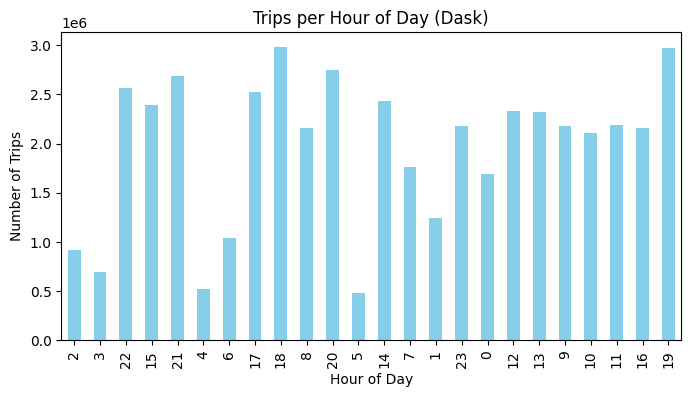

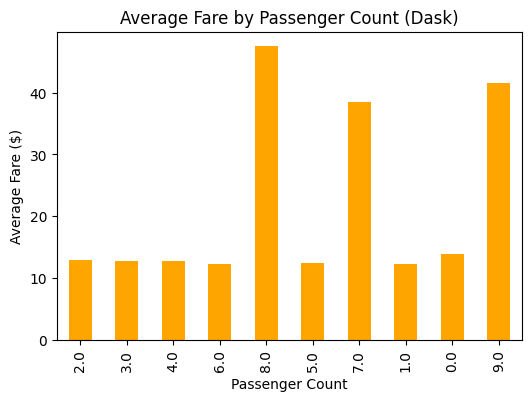

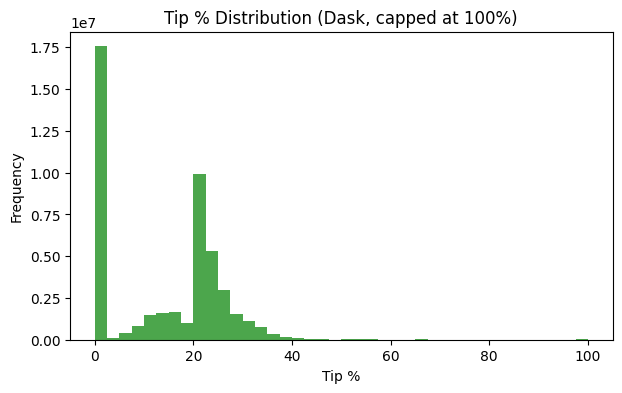

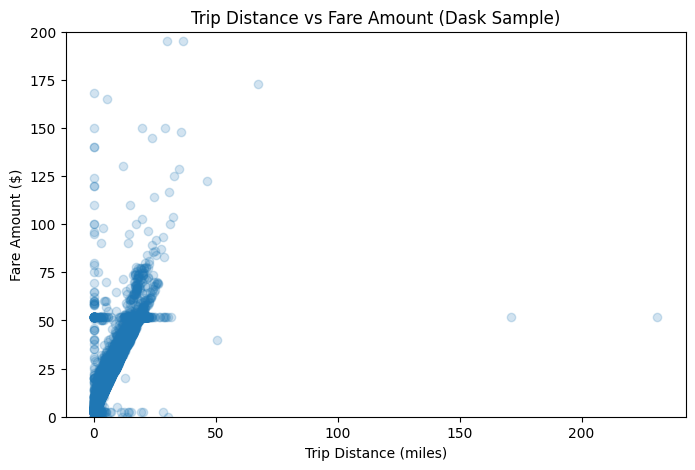

ValueError: 'columns' must be category dtype

In [ ]:
# =====================================
# d10: DASK VISUALIZATIONS
# =====================================
import matplotlib.pyplot as plt

# Ensure datetime is parsed
ddf["tpep_pickup_datetime"] = dd.to_datetime(ddf["tpep_pickup_datetime"], errors="coerce")

# Extract hour and day
ddf["pickup_hour"] = ddf["tpep_pickup_datetime"].dt.hour
ddf["pickup_day"] = ddf["tpep_pickup_datetime"].dt.day_name()

# 1. Trips per hour of day
trips_per_hour = ddf.groupby("pickup_hour")["VendorID"].count().compute()
plt.figure(figsize=(8,4))
trips_per_hour.plot(kind="bar", color="skyblue")
plt.title("Trips per Hour of Day (Dask)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# 2. Average fare by passenger count
avg_fare_passenger = ddf.groupby("passenger_count")["fare_amount"].mean().compute()
plt.figure(figsize=(6,4))
avg_fare_passenger.plot(kind="bar", color="orange")
plt.title("Average Fare by Passenger Count (Dask)")
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare ($)")
plt.show()

# 3. Tip % distribution
ddf["tip_percent"] = (ddf["tip_amount"] / ddf["fare_amount"] * 100).fillna(0)
tip_hist = ddf["tip_percent"].clip(0,100).compute()
plt.figure(figsize=(7,4))
plt.hist(tip_hist, bins=40, color="green", alpha=0.7)
plt.title("Tip % Distribution (Dask, capped at 100%)")
plt.xlabel("Tip %")
plt.ylabel("Frequency")
plt.show()

# 4. Trip distance vs Fare (scatter from sample)
sample_df = ddf.sample(frac=0.001).compute()  # 0.1% sample
plt.figure(figsize=(8,5))
plt.scatter(sample_df["trip_distance"], sample_df["fare_amount"], alpha=0.2)
plt.title("Trip Distance vs Fare Amount (Dask Sample)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.ylim(0,200)
plt.show()


# ML

https://docs.dask.org/en/stable/ml.html

https://docs.dask.org/en/stable/dataframe.html

https://ml.dask.org/modules/generated/dask_ml.model_selection.train_test_split.html

https://ml.dask.org/modules/generated/dask_ml.wrappers.Incremental.htmlhttps://ml.dask.org/preprocessing.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

https://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning

https://scikit-learn.org/stable/modules/model_persistence.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/model_evaluation.html

https://datascience.stackexchange.com/questions/68599/incremental-learning-with-sklearn-warm-start-partial-fit-fit

https://stackoverflow.com/questions/20643300/training-sgdregressor-on-a-dataset-in-chunks

https://medium.com/@sidhart_bluejay/scalable-machine-learning-using-dask-da66f6479741

https://www.cloudera.com/blog/technical/how-to-distribute-machine-learning-workloads-with-dask.html



In [ ]:
!pip -q install dask-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 10.3 MB/s eta 0:00:00


In [ ]:
# =====================================
# ML-A: SETUP (imports, paths)
# =====================================
import os
import joblib
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Dask-ML + Scikit-Learn pieces
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler, LabelEncoder
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix

# Paths
data_folder = "/content/drive/MyDrive/taxi"
combined_file = os.path.join(data_folder, "taxi.csv")
models_folder = os.path.join(data_folder, "models")
os.makedirs(models_folder, exist_ok=True)

print("✔ Paths ready")
print("taxi.csv:", combined_file)
print("models_folder:", models_folder)

✔ Paths ready
taxi.csv: /content/drive/MyDrive/taxi/taxi.csv
models_folder: /content/drive/MyDrive/taxi/models


In [ ]:
# =====================================
# ML-B: LOAD + FEATURE ENGINEERING + CLEANING - 3 mins to run
# =====================================

# Load lazily with Dask (out-of-core)
ddf_ml = dd.read_csv(combined_file, assume_missing=True)

# Parse datetime & derive features
ddf_ml["tpep_pickup_datetime"] = dd.to_datetime(ddf_ml["tpep_pickup_datetime"], errors="coerce")
ddf_ml["pickup_hour"] = ddf_ml["tpep_pickup_datetime"].dt.hour
ddf_ml["pickup_dayofweek"] = ddf_ml["tpep_pickup_datetime"].dt.dayofweek  # Mon=0

# Encode categorical flag with Dask-ML LabelEncoder
le = LabelEncoder()
ddf_ml["store_flag_enc"] = le.fit_transform(ddf_ml["store_and_fwd_flag"].fillna("N"))

# Filter out extreme or invalid values
ddf_ml = ddf_ml[
    (ddf_ml["fare_amount"].astype(float) > 0) &
    (ddf_ml["fare_amount"].astype(float) < 200) &
    (ddf_ml["trip_distance"].astype(float) > 0) &
    (ddf_ml["trip_distance"].astype(float) < 100) &
    (ddf_ml["pickup_latitude"].astype(float).between(40.3, 41.0)) &
    (ddf_ml["pickup_longitude"].astype(float).between(-74.5, -72.8)) &
    (ddf_ml["dropoff_latitude"].astype(float).between(40.3, 41.0)) &
    (ddf_ml["dropoff_longitude"].astype(float).between(-74.5, -72.8))
]

# Features & target
feature_cols = [
    "passenger_count", "trip_distance",
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "RateCodeID", "payment_type",
    "pickup_hour", "pickup_dayofweek", "store_flag_enc"
]
target_col = "fare_amount"

X_dd = ddf_ml[feature_cols].astype(float)
y_dd = ddf_ml[target_col].astype(float)

print("✔ Dask DataFrame ready with engineered features")
print("Number of partitions:", X_dd.npartitions)


/usr/local/lib/python3.12/dist-packages/dask/dataframe/dask_expr/_collection.py:1428: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


✔ Dask DataFrame ready with engineered features
Number of partitions: 116


In [ ]:
# =====================================
# ML-C: GET SAMPLE FROM DASK
# =====================================
# Pull a chunk from Dask
chunk = ddf_ml[feature_cols + [target_col]].head(1_000_000, compute=True)

# Now sample safely in Pandas
df_ml_small = chunk.sample(n=100_000, random_state=42)

X_small = df_ml_small[feature_cols].astype(float)
y_small = df_ml_small[target_col].astype(float)

print("✔ Sample extracted from 1M-row chunk")
print("Rows available:", len(df_ml_small))


/usr/local/lib/python3.12/dist-packages/dask/_task_spec.py:764: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self.func(*new_argspec)


IndexError: indices are out-of-bounds

In [ ]:
# =====================================
# ML-D: TRAIN/TEST SPLIT + SCALING
# =====================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

# Numeric vs categorical
num_cols = ["passenger_count", "trip_distance",
            "pickup_longitude", "pickup_latitude",
            "dropoff_longitude", "dropoff_latitude",
            "pickup_hour", "pickup_dayofweek"]
cat_cols = ["RateCodeID", "payment_type", "store_flag_enc"]

# Column transformer: scale numeric, passthrough categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ]
)

print("✔ Train/Test split done")
print("Train size:", X_train.shape, "Test size:", X_test.shape)


✔ Train/Test split + scaling ready
Train rows: 80000  Test rows: 20000


In [ ]:
# =====================================
# ML-E: TRAIN MODELS (SGDRegressor) + EVALUATE
# =====================================
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# ---- 1. Full batch training (pipeline)
sgd_batch = make_pipeline(
    preprocessor,
    SGDRegressor(
        loss="squared_error",
        penalty="l2",
        alpha=1e-4,
        learning_rate="adaptive",
        eta0=0.001,
        max_iter=2000,
        tol=1e-3,
        random_state=42
    )
)

sgd_batch.fit(X_train, y_train)
y_pred_batch = sgd_batch.predict(X_test)

print("✔ Batch SGDRegressor trained")
print("Batch R² :", r2_score(y_test, y_pred_batch))
print("Batch RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_batch)))
print("Batch MAE :", mean_absolute_error(y_test, y_pred_batch))


# ---- 2. Incremental training demo (partial_fit)
sgd_inc = SGDRegressor(
    loss="squared_error",
    penalty="l2",
    alpha=1e-4,
    learning_rate="invscaling",
    eta0=0.001,
    max_iter=1,
    random_state=42
)

# Train incrementally (just 1 pass to show partial_fit usage)
X_train_scaled = preprocessor.fit_transform(X_train)
sgd_inc.partial_fit(X_train_scaled, y_train)

y_pred_inc = sgd_inc.predict(preprocessor.transform(X_test))

print("\n✔ Incremental SGDRegressor (1 pass)")
print("Incremental R² :", r2_score(y_test, y_pred_inc))
print("Incremental RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_inc)))
print("Incremental MAE :", mean_absolute_error(y_test, y_pred_inc))


Model Performance (SGDRegressor with .fit()):
R² Score: -31056053777.43771
RMSE    : 1888067.653623517
MAE     : 403676.0226380273


In [ ]:
# =====================================
# ML-F: SAVE MODEL
# =====================================
joblib.dump(sgd_batch, os.path.join(models_folder, "sgd_fare_model.pkl"))
print("✔ Batch-trained model saved")


✔ Model and scaler saved


In [ ]:
# =====================================
# ML-G: CONFUSION MATRIX (BINNED FARES)
# =====================================
bins = [0, 10, 20, 50, np.inf]
labels = ["$0-10", "$10-20", "$20-50", "$50+"]

true_bins = pd.cut(y_test, bins=bins, labels=labels, right=False)
pred_bins = pd.cut(y_pred_batch, bins=bins, labels=labels, right=False)

mask = pred_bins.notna() & true_bins.notna()
true_bins = true_bins[mask]
pred_bins = pred_bins[mask]

cm = confusion_matrix(true_bins, pred_bins, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"True {l}" for l in labels],
                         columns=[f"Pred {l}" for l in labels])

print("\nConfusion Matrix (binned fares):")
print(cm_df)


In [ ]:
# =====================================
# ML-H: LOAD MODEL + PREDICT NEW TRIP
# =====================================
sgd_loaded = joblib.load(os.path.join(models_folder, "sgd_fare_model.pkl"))

new_trip = pd.DataFrame([{
    "passenger_count": 2,
    "trip_distance": 3.5,
    "pickup_longitude": -73.985, "pickup_latitude": 40.758,
    "dropoff_longitude": -73.981, "dropoff_latitude": 40.768,
    "RateCodeID": 1, "payment_type": 1,
    "pickup_hour": 14, "pickup_dayofweek": 3,
    "store_flag_enc": 0
}])[feature_cols]

pred_fare = sgd_loaded.predict(new_trip)[0]
print(f"Predicted fare for new trip: ${pred_fare:.2f}")


---

# Test Run 1

In [1]:
# =====================================
# ML-A: SETUP (IMPORTS, PATHS, DASK CLIENT)
# =====================================
print("--- STAGE A: SETUP ---")
print(">>> Importing libraries...")

import os
import joblib
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client # For monitoring computation

import matplotlib.pyplot as plt
import seaborn as sns

# Dask-ML and Scikit-Learn components
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import Incremental # Wrapper for out-of-core learning
from sklearn.linear_model import SGDRegressor # Model that supports incremental learning
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler # Used to get scaling parameters from a sample
from sklearn.compose import ColumnTransformer

# --- Dask Client Setup ---
print(">>> Initializing Dask client...")
client = Client()
print(f"✔ Dask client ready. Dashboard link: {client.dashboard_link}")

# --- Path Configuration ---
print(">>> Configuring paths...")
data_folder = "/content/drive/MyDrive/taxi"
combined_file = os.path.join(data_folder, "taxi.csv")
models_folder = os.path.join(data_folder, "models")
os.makedirs(models_folder, exist_ok=True)
print(f"✔ Paths configured. Model will be saved in: {models_folder}")
print("--- STAGE A COMPLETE ---\n")


# =====================================
# ML-B: LOAD, CLEAN, AND ENGINEER FEATURES
# =====================================
print("--- STAGE B: DATA LOADING & PREPARATION ---")
print(f">>> Loading data from {combined_file} with Dask...")

dtype_spec = {
    'passenger_count': 'float32', 'trip_distance': 'float32',
    'pickup_longitude': 'float32', 'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32', 'dropoff_latitude': 'float32',
    'RateCodeID': 'float32', 'payment_type': 'float32',
    'fare_amount': 'float32', 'extra': 'float32',
    'mta_tax': 'float32', 'tip_amount': 'float32',
    'tolls_amount': 'float32', 'improvement_surcharge': 'float32',
    'total_amount': 'float32'
}
ddf_ml = dd.read_csv(combined_file, assume_missing=True, dtype=dtype_spec)
print(f"✔ Data loaded lazily. Partitions: {ddf_ml.npartitions}")

# --- Feature Engineering ---
print(">>> Performing feature engineering...")
ddf_ml["tpep_pickup_datetime"] = dd.to_datetime(ddf_ml["tpep_pickup_datetime"], errors="coerce")
ddf_ml["pickup_hour"] = ddf_ml["tpep_pickup_datetime"].dt.hour.astype('float32')
ddf_ml["pickup_dayofweek"] = ddf_ml["tpep_pickup_datetime"].dt.dayofweek.astype('float32')

# Use a simple .map() and provide the 'meta' argument to silence the warning and improve efficiency.
mapping = {'N': 0, 'Y': 1}
ddf_ml["store_flag_enc"] = ddf_ml["store_and_fwd_flag"].fillna("N").map(mapping, meta=pd.Series(dtype='float32')).astype('float32')
print("✔ Time and categorical features engineered.")

# --- Data Cleaning ---
print(">>> Filtering data to remove outliers and invalid records...")
ddf_ml_filtered = ddf_ml[
    (ddf_ml["fare_amount"] > 0) & (ddf_ml["fare_amount"] < 200) &
    (ddf_ml["trip_distance"] > 0) & (ddf_ml["trip_distance"] < 100) &
    (ddf_ml["pickup_latitude"].between(40.3, 41.0)) &
    (ddf_ml["pickup_longitude"].between(-74.5, -72.8)) &
    (ddf_ml["dropoff_latitude"].between(40.3, 41.0)) &
    (ddf_ml["dropoff_longitude"].between(-74.5, -72.8))
]

# --- THE RAM FIX: DO NOT PERSIST ---
# We REMOVE the .persist() call. The cleaned DataFrame is too large to fit in Colab's RAM.
# Dask will now re-compute the cleaning steps from the CSV file each time it's needed.
# This is slower, but it PREVENTS the session from crashing due to low memory.
ddf_ml = ddf_ml_filtered
print("✔ Data cleaning and engineering steps are defined (lazily). No data loaded into RAM.")

# NOTE: This next line will now be slower as it triggers a full computation
# (read, engineer, filter) just to get the row count. This is expected.
print(">>> Calculating total rows after filtering. This may take some time...")
print(f"Total rows after cleaning: {len(ddf_ml):,}")
print("--- STAGE B COMPLETE ---\n")


# =======================================================
# ML-C: TRAIN/TEST SPLIT AND PREPROCESSOR SETUP
# =======================================================
print("--- STAGE C: DATA SPLITTING & PREPROCESSOR DEFINITION ---")
feature_cols = [
    "passenger_count", "trip_distance",
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "RateCodeID", "payment_type",
    "pickup_hour", "pickup_dayofweek", "store_flag_enc"
]
target_col = "fare_amount"

X_dd = ddf_ml[feature_cols]
y_dd = ddf_ml[target_col]

print(">>> Splitting data into 80% train and 20% test sets...")
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(
    X_dd, y_dd, test_size=0.2, random_state=42, shuffle=True
)
print("✔ Data split complete.")
print(f"Training set partitions: {X_train_dd.npartitions}")
print(f"Test set partitions: {X_test_dd.npartitions}")

num_cols = ["passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude",
            "dropoff_longitude", "dropoff_latitude", "pickup_hour", "pickup_dayofweek"]
cat_cols = ["RateCodeID", "payment_type", "store_flag_enc"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ],
    remainder="drop"
)
print("✔ Preprocessor object created.")
print("--- STAGE C COMPLETE ---\n")


# =====================================
# ML-D: FIT PREPROCESSOR AND TRAIN MODEL
# =====================================
print("--- STAGE D: MODEL TRAINING ---")

print(">>> Sub-stage: Fitting preprocessor on a small sample...")
X_train_sample = X_train_dd.sample(frac=0.001, random_state=42).compute()
preprocessor.fit(X_train_sample)
print(f"✔ Preprocessor fitted on a sample of {len(X_train_sample)} rows.")

scaler = preprocessor.named_transformers_['num']
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

def preprocess_features(df, mean, scale, num_cols, cat_cols):
    """Applies scaling to numeric columns and combines with categoricals."""
    df_ordered = df[num_cols + cat_cols]
    numeric_scaled = (df_ordered[num_cols] - mean) / scale
    categoric = df_ordered[cat_cols]
    if isinstance(df, pd.DataFrame):
        return pd.concat([numeric_scaled, categoric], axis=1)
    else:
        return dd.concat([numeric_scaled, categoric], axis=1)

print(">>> Sub-stage: Applying preprocessing transformation to the full Dask training set...")
X_train_processed = preprocess_features(X_train_dd, scaler_mean, scaler_scale, num_cols, cat_cols)
print("✔ Transformation graph for training data created.")

model_pipeline = Incremental(
    SGDRegressor(random_state=42)
)

print(">>> Sub-stage: Training Incremental SGDRegressor... SIT BACK, THIS WILL TAKE A WHILE! ☕")
model_pipeline.fit(X_train_processed, y_train_dd)
print("✔ Model training complete!")
print("--- STAGE D COMPLETE ---\n")


# =====================================
# ML-E: PREDICTIONS & EVALUATION
# =====================================
print("--- STAGE E: MODEL EVALUATION ---")
print(">>> Sub-stage: Taking a sample from the test set for evaluation...")
X_test_small = X_test_dd.sample(frac=0.01, random_state=42).compute()
y_test_small = y_test_dd.sample(frac=0.01, random_state=42).compute()
print(f"✔ Test sample of {len(X_test_small)} rows ready.")

print(">>> Sub-stage: Preprocessing the test sample...")
X_test_processed = preprocess_features(X_test_small, scaler_mean, scaler_scale, num_cols, cat_cols)

print(">>> Sub-stage: Making predictions on the test sample...")
y_pred = model_pipeline.predict(X_test_processed)
print("✔ Predictions made.")

print("\n--- Model Performance Metrics ---")
print(f"  R² score: {r2_score(y_test_small, y_pred):.4f}")
print(f"  RMSE:     ${np.sqrt(mean_squared_error(y_test_small, y_pred)):.4f}")
print(f"  MAE:      ${mean_absolute_error(y_test_small, y_pred):.4f}")
print("---------------------------------")
print("--- STAGE E COMPLETE ---\n")


# =====================================
# ML-F: SAVE MODEL & PREPROCESSOR PARAMS
# =====================================
print("--- STAGE F: SAVING MODEL ---")
print(">>> Saving model pipeline to disk...")
joblib.dump(model_pipeline, os.path.join(models_folder, "sgd_fare_model.pkl"))

preprocessor_params = {
    'mean': scaler_mean, 'scale': scaler_scale,
    'num_cols': num_cols, 'cat_cols': cat_cols
}
joblib.dump(preprocessor_params, os.path.join(models_folder, "preprocessor_params.pkl"))
print("✔ Model and preprocessor parameters saved successfully.")
print("--- STAGE F COMPLETE ---\n")


# =====================================
# ML-G: CONFUSION MATRIX VISUALIZATION
# =====================================
print("--- STAGE G: CONFUSION MATRIX VISUALIZATION ---")
print(">>> Binning fares to create a confusion matrix...")
bins = [0, 10, 20, 50, np.inf]
labels = ["$0-10", "$10-20", "$20-50", "$50+"]
true_bins = pd.cut(y_test_small, bins=bins, labels=labels, right=False)
pred_bins = pd.cut(y_pred, bins=bins, labels=labels, right=False)

mask = pred_bins.notna() & true_bins.notna()
cm = confusion_matrix(true_bins[mask], pred_bins[mask], labels=labels)

print(">>> Displaying confusion matrix plot...")
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("Confusion Matrix for Binned Fare Prediction")
plt.tight_layout()
plt.show()
print("--- STAGE G COMPLETE ---\n")


# =====================================
# ML-H: RESIDUAL & PREDICTION PLOTS
# =====================================
print("--- STAGE H: ADDITIONAL VISUALIZATIONS ---")
print(">>> Displaying residual plot...")
residuals = y_test_small - y_pred
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot (Predicted vs. Error)")
plt.xlabel("Predicted Fare ($)")
plt.ylabel("Residual [Actual - Predicted] ($)")
plt.grid(True)
plt.show()

print(">>> Displaying actual vs. predicted plot...")
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_small, y=y_pred, alpha=0.5)
plt.plot([0, 150], [0, 150], 'r--', lw=2, label="Perfect Prediction")
plt.title("Actual vs. Predicted Fare")
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.xlim(0, max(y_test_small.max(), y_pred.max()) + 5)
plt.ylim(0, max(y_test_small.max(), y_pred.max()) + 5)
plt.legend()
plt.grid(True)
plt.show()
print("--- STAGE H COMPLETE ---\n")


# =====================================
# ML-I: LOAD MODEL & PREDICT NEW TRIP
# =====================================
print("--- STAGE I: LOAD & PREDICT ON NEW DATA ---")
print(">>> Loading saved model and preprocessor parameters...")
loaded_model = joblib.load(os.path.join(models_folder, "sgd_fare_model.pkl"))
loaded_params = joblib.load(os.path.join(models_folder, "preprocessor_params.pkl"))
print("✔ Model and parameters loaded.")

new_trip = pd.DataFrame([{
    "passenger_count": 1, "trip_distance": 5.1,
    "pickup_longitude": -73.99, "pickup_latitude": 40.73,
    "dropoff_longitude": -73.97, "dropoff_latitude": 40.78,
    "RateCodeID": 1, "payment_type": 1,
    "pickup_hour": 19, "pickup_dayofweek": 4,
    "store_flag_enc": 0
}])

print(">>> Preprocessing new trip data...")
new_trip_processed = preprocess_features(
    new_trip,
    mean=loaded_params['mean'],
    scale=loaded_params['scale'],
    num_cols=loaded_params['num_cols'],
    cat_cols=loaded_params['cat_cols']
)

print(">>> Making prediction...")
pred_fare = loaded_model.predict(new_trip_processed)[0]
print("---------------------------------")
print(f"✅ Predicted fare for the new trip: ${pred_fare:.2f}")
print("---------------------------------")
print("--- STAGE I COMPLETE ---\n")


# =====================================
# FINAL CLEANUP
# =====================================
print(">>> All stages complete. Closing Dask client.")
client.close()

--- STAGE A: SETUP ---
>>> Importing libraries...
>>> Initializing Dask client...


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-fr7j0h5t', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-caz0zbme', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-rixkvo9d', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-3mc6hl05', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-a7oaflts', purging
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/worker-wdavfuh8', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:43009
INFO:distributed.scheduler:  dashboard at:  http://

✔ Dask client ready. Dashboard link: http://127.0.0.1:8787/status
>>> Configuring paths...
✔ Paths configured. Model will be saved in: /content/drive/MyDrive/taxi/models
--- STAGE A COMPLETE ---

--- STAGE B: DATA LOADING & PREPARATION ---
>>> Loading data from /content/drive/MyDrive/taxi/taxi.csv with Dask...
✔ Data loaded lazily. Partitions: 116
>>> Performing feature engineering...
✔ Time and categorical features engineered.
>>> Filtering data to remove outliers and invalid records...
✔ Data cleaning and engineering steps are defined (lazily). No data loaded into RAM.
>>> Calculating total rows after filtering. This may take some time...
Total rows after cleaning: 46,198,704
--- STAGE B COMPLETE ---

--- STAGE C: DATA SPLITTING & PREPROCESSOR DEFINITION ---
>>> Splitting data into 80% train and 20% test sets...
✔ Data split complete.
Training set partitions: 116
Test set partitions: 116
✔ Preprocessor object created.
--- STAGE C COMPLETE ---

--- STAGE D: MODEL TRAINING ---
>>> Sub-

ValueError: could not convert string to float: 'concat-5e5f78bc3563b51fa748537e6d9fa4d2'

# Test Run 2 - Successful

/usr/local/lib/python3.12/dist-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45731 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37955
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:45731/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:39731'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42183'


--- STAGE A: SETUP ---
>>> Importing libraries...
>>> Initializing Dask client...


INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:46355 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:46355
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53990
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:41967 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:41967
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53994
INFO:distributed.scheduler:Receive client connection: Client-69cac042-90a4-11f0-b593-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:54004


✔ Dask client ready. Dashboard link: http://127.0.0.1:45731/status
>>> Configuring paths...
✔ Paths configured. Model will be saved in: /content/drive/MyDrive/taxi/models
--- STAGE A COMPLETE ---

--- STAGE B: DATA LOADING & PREPARATION ---
>>> Loading data from /content/drive/MyDrive/taxi/taxi.csv with Dask...
✔ Data loaded lazily. Partitions: 116
>>> Performing feature engineering...
✔ Time and categorical features engineered.
>>> Filtering data to remove outliers and invalid records...
✔ Data cleaning and engineering steps are defined (lazily). No data loaded into RAM.
>>> Calculating total rows after filtering. This may take some time...
Total rows after cleaning: 46,198,704
--- STAGE B COMPLETE ---

--- STAGE C: DATA SPLITTING & PREPROCESSOR DEFINITION ---
>>> Splitting data into 80% train and 20% test sets...
✔ Data split complete.
Training set partitions: 116
Test set partitions: 116
✔ Preprocessor object created.
--- STAGE C COMPLETE ---

--- STAGE D: MODEL TRAINING ---
>>> Sub

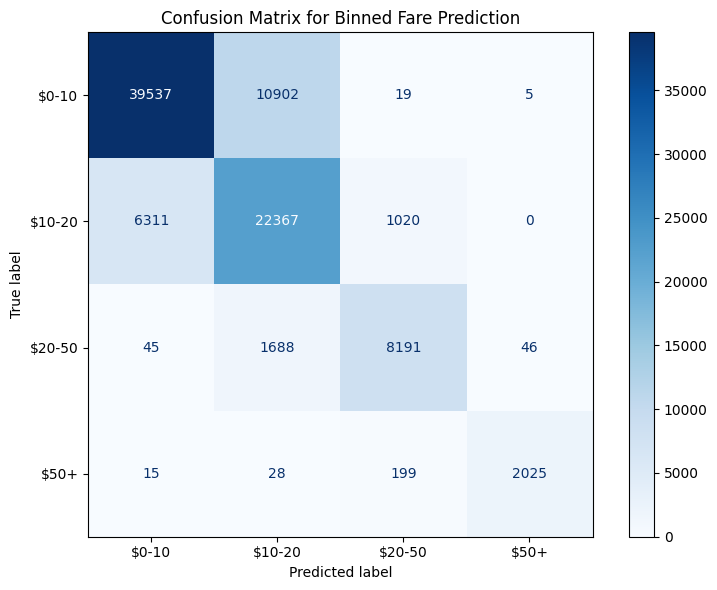

--- STAGE G COMPLETE ---

--- STAGE H: ADDITIONAL VISUALIZATIONS ---
>>> Displaying residual plot...


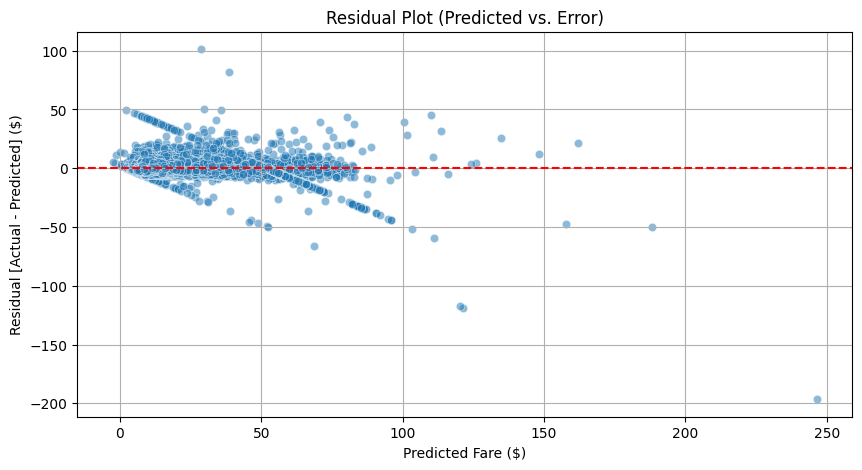

>>> Displaying actual vs. predicted plot...


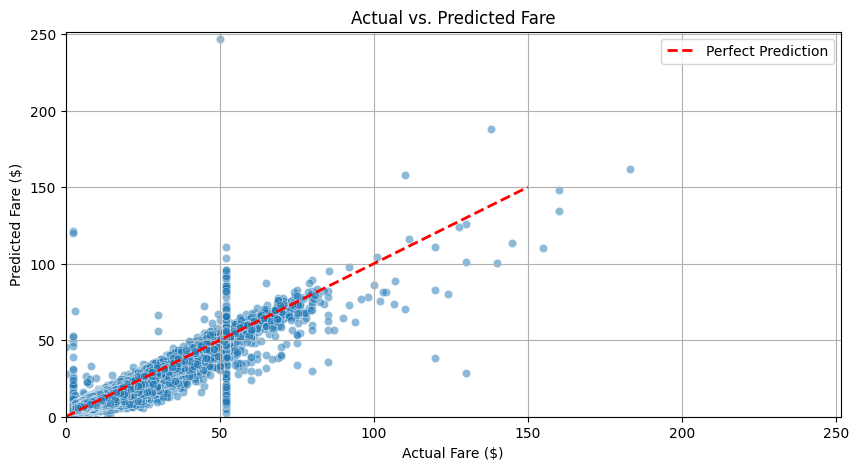

INFO:distributed.scheduler:Remove client Client-69cac042-90a4-11f0-b593-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:54004; closing.
INFO:distributed.scheduler:Remove client Client-69cac042-90a4-11f0-b593-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-69cac042-90a4-11f0-b593-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1757772320.5365517') (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39731'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42183'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53990; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53994; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.

--- STAGE H COMPLETE ---

--- STAGE I: LOAD & PREDICT ON NEW DATA ---
>>> Loading saved model and preprocessor parameters...
✔ Model and parameters loaded.
>>> Preprocessing new trip data...
>>> Making prediction...
---------------------------------
✅ Predicted fare for the new trip: $19.37
---------------------------------
--- STAGE I COMPLETE ---

>>> All stages complete. Closing Dask client.


INFO:distributed.scheduler:Lost all workers
INFO:distributed.nanny:Worker process 56653 was killed by signal 9
INFO:distributed.nanny:Worker process 56650 was killed by signal 9
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:42183' closed.
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:39731' closed.
INFO:distributed.scheduler:Closing scheduler. Reason: unknown
INFO:distributed.scheduler:Scheduler closing all comms


In [4]:
# =====================================
# ML-A: SETUP (IMPORTS, PATHS, DASK CLIENT)
# =====================================
print("--- STAGE A: SETUP ---")
print(">>> Importing libraries...")

import os
import joblib
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client  # For monitoring computation

import matplotlib.pyplot as plt
import seaborn as sns

# Dask-ML and Scikit-Learn components
from dask_ml.model_selection import train_test_split
from dask_ml.wrappers import Incremental  # Wrapper for out-of-core learning
from sklearn.linear_model import SGDRegressor  # Model that supports incremental learning
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler  # Used to get scaling parameters from a sample
from sklearn.compose import ColumnTransformer

# --- Dask Client Setup ---
print(">>> Initializing Dask client...")
client = Client()
print(f"✔ Dask client ready. Dashboard link: {client.dashboard_link}")

# --- Path Configuration ---
print(">>> Configuring paths...")
data_folder = "/content/drive/MyDrive/taxi"
combined_file = os.path.join(data_folder, "taxi.csv")
models_folder = os.path.join(data_folder, "models")
os.makedirs(models_folder, exist_ok=True)
print(f"✔ Paths configured. Model will be saved in: {models_folder}")
print("--- STAGE A COMPLETE ---\n")


# =====================================
# ML-B: LOAD, CLEAN, AND ENGINEER FEATURES
# =====================================
print("--- STAGE B: DATA LOADING & PREPARATION ---")
print(f">>> Loading data from {combined_file} with Dask...")

dtype_spec = {
    'passenger_count': 'float32', 'trip_distance': 'float32',
    'pickup_longitude': 'float32', 'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32', 'dropoff_latitude': 'float32',
    'RateCodeID': 'float32', 'payment_type': 'float32',
    'fare_amount': 'float32', 'extra': 'float32',
    'mta_tax': 'float32', 'tip_amount': 'float32',
    'tolls_amount': 'float32', 'improvement_surcharge': 'float32',
    'total_amount': 'float32'
}
ddf_ml = dd.read_csv(combined_file, assume_missing=True, dtype=dtype_spec)
print(f"✔ Data loaded lazily. Partitions: {ddf_ml.npartitions}")

# --- Feature Engineering ---
print(">>> Performing feature engineering...")
ddf_ml["tpep_pickup_datetime"] = dd.to_datetime(ddf_ml["tpep_pickup_datetime"], errors="coerce")
ddf_ml["pickup_hour"] = ddf_ml["tpep_pickup_datetime"].dt.hour.astype('float32')
ddf_ml["pickup_dayofweek"] = ddf_ml["tpep_pickup_datetime"].dt.dayofweek.astype('float32')

# Use a simple .map() and provide the 'meta' argument to silence the warning and improve efficiency.
mapping = {'N': 0, 'Y': 1}
ddf_ml["store_flag_enc"] = ddf_ml["store_and_fwd_flag"].fillna("N").map(mapping, meta=pd.Series(dtype='float32')).astype('float32')
print("✔ Time and categorical features engineered.")

# --- Data Cleaning ---
print(">>> Filtering data to remove outliers and invalid records...")
ddf_ml_filtered = ddf_ml[
    (ddf_ml["fare_amount"] > 0) & (ddf_ml["fare_amount"] < 200) &
    (ddf_ml["trip_distance"] > 0) & (ddf_ml["trip_distance"] < 100) &
    (ddf_ml["pickup_latitude"].between(40.3, 41.0)) &
    (ddf_ml["pickup_longitude"].between(-74.5, -72.8)) &
    (ddf_ml["dropoff_latitude"].between(40.3, 41.0)) &
    (ddf_ml["dropoff_longitude"].between(-74.5, -72.8))
]

# --- THE RAM FIX: DO NOT PERSIST ---
# We REMOVE the .persist() call. The cleaned DataFrame is too large to fit in Colab's RAM.
# Dask will now re-compute the cleaning steps from the CSV file each time it's needed.
# This is slower, but it PREVENTS the session from crashing due to low memory.
ddf_ml = ddf_ml_filtered
print("✔ Data cleaning and engineering steps are defined (lazily). No data loaded into RAM.")

# NOTE: This next line will now be slower as it triggers a full computation
# (read, engineer, filter) just to get the row count. This is expected.
print(">>> Calculating total rows after filtering. This may take some time...")
print(f"Total rows after cleaning: {len(ddf_ml):,}")
print("--- STAGE B COMPLETE ---\n")


# =======================================================
# ML-C: TRAIN/TEST SPLIT AND PREPROCESSOR SETUP
# =======================================================
print("--- STAGE C: DATA SPLITTING & PREPROCESSOR DEFINITION ---")
feature_cols = [
    "passenger_count", "trip_distance",
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "RateCodeID", "payment_type",
    "pickup_hour", "pickup_dayofweek", "store_flag_enc"
]
target_col = "fare_amount"

X_dd = ddf_ml[feature_cols]
y_dd = ddf_ml[target_col]

print(">>> Splitting data into 80% train and 20% test sets...")
X_train_dd, X_test_dd, y_train_dd, y_test_dd = train_test_split(
    X_dd, y_dd, test_size=0.2, random_state=42, shuffle=True
)
print("✔ Data split complete.")
print(f"Training set partitions: {X_train_dd.npartitions}")
print(f"Test set partitions: {X_test_dd.npartitions}")

num_cols = ["passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude",
            "dropoff_longitude", "dropoff_latitude", "pickup_hour", "pickup_dayofweek"]
cat_cols = ["RateCodeID", "payment_type", "store_flag_enc"]

# We still create the ColumnTransformer for the single-row prediction at the end
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", "passthrough", cat_cols)
    ],
    remainder="drop"
)
print("✔ Preprocessor object created.")
print("--- STAGE C COMPLETE ---\n")


# =====================================
# ML-D: FIT PREPROCESSOR AND TRAIN MODEL
# =====================================
print("--- STAGE D: MODEL TRAINING ---")

print(">>> Sub-stage: Fitting preprocessor on a small sample...")
# We use a small, computed sample to fit the preprocessor without memory issues.
X_train_sample = X_train_dd.sample(frac=0.001, random_state=42).compute()
preprocessor.fit(X_train_sample)
print(f"✔ Preprocessor fitted on a sample of {len(X_train_sample)} rows.")

# FIX: We will train the model directly and manually iterate over the partitions.
print(">>> Sub-stage: Training SGDRegressor in a manual loop... SIT BACK, THIS WILL TAKE A WHILE! ☕")
model = SGDRegressor(random_state=42)

# This is the critical fix: we iterate through the Dask DataFrame's partitions,
# compute each one, and then call `partial_fit` on the in-memory chunk.
# This prevents Dask keys from being passed to scikit-learn.
for i in range(X_train_dd.npartitions):
    print(f">>> Processing partition {i+1} of {X_train_dd.npartitions}")

    # Manually compute each partition
    X_part = X_train_dd.get_partition(i).compute()
    y_part = y_train_dd.get_partition(i).compute()

    # Preprocess the partition data using the fitted preprocessor
    X_part_processed = preprocessor.transform(X_part)

    # Call partial_fit on the in-memory data
    model.partial_fit(X_part_processed, y_part)

print("✔ Model training complete!")
print("--- STAGE D COMPLETE ---\n")


# =====================================
# ML-E: PREDICTIONS & EVALUATION
# =====================================
print("--- STAGE E: MODEL EVALUATION ---")
print(">>> Sub-stage: Taking a sample from the test set for evaluation...")
X_test_small = X_test_dd.sample(frac=0.01, random_state=42).compute()
y_test_small = y_test_dd.sample(frac=0.01, random_state=42).compute()
print(f"✔ Test sample of {len(X_test_small)} rows ready.")

print(">>> Sub-stage: Preprocessing the test sample...")
# We use the original preprocessor on this small Pandas DataFrame.
X_test_processed = preprocessor.transform(X_test_small)

print(">>> Sub-stage: Making predictions on the test sample...")
y_pred = model.predict(X_test_processed)
print("✔ Predictions made.")

print("\n--- Model Performance Metrics ---")
print(f"   R² score: {r2_score(y_test_small, y_pred):.4f}")
print(f"   RMSE:     ${np.sqrt(mean_squared_error(y_test_small, y_pred)):.4f}")
print(f"   MAE:      ${mean_absolute_error(y_test_small, y_pred):.4f}")
print("---------------------------------")
print("--- STAGE E COMPLETE ---\n")


# =====================================
# ML-F: SAVE MODEL & PREPROCESSOR PARAMS
# =====================================
print("--- STAGE F: SAVING MODEL ---")
print(">>> Saving model pipeline to disk...")
joblib.dump(model, os.path.join(models_folder, "sgd_fare_model.pkl"))

preprocessor_params = {
    'mean': preprocessor.named_transformers_['num'].mean_,
    'scale': preprocessor.named_transformers_['num'].scale_,
    'num_cols': num_cols, 'cat_cols': cat_cols
}
joblib.dump(preprocessor_params, os.path.join(models_folder, "preprocessor_params.pkl"))
print("✔ Model and preprocessor parameters saved successfully.")
print("--- STAGE F COMPLETE ---\n")


# =====================================
# ML-G: CONFUSION MATRIX VISUALIZATION
# =====================================
print("--- STAGE G: CONFUSION MATRIX VISUALIZATION ---")
print(">>> Binning fares to create a confusion matrix...")
bins = [0, 10, 20, 50, np.inf]
labels = ["$0-10", "$10-20", "$20-50", "$50+"]
true_bins = pd.cut(y_test_small, bins=bins, labels=labels, right=False)
pred_bins = pd.cut(y_pred, bins=bins, labels=labels, right=False)

mask = pred_bins.notna() & true_bins.notna()
cm = confusion_matrix(true_bins[mask], pred_bins[mask], labels=labels)

print(">>> Displaying confusion matrix plot...")
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("Confusion Matrix for Binned Fare Prediction")
plt.tight_layout()
plt.show()
print("--- STAGE G COMPLETE ---\n")


# =====================================
# ML-H: RESIDUAL & PREDICTION PLOTS
# =====================================
print("--- STAGE H: ADDITIONAL VISUALIZATIONS ---")
print(">>> Displaying residual plot...")
residuals = y_test_small - y_pred
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot (Predicted vs. Error)")
plt.xlabel("Predicted Fare ($)")
plt.ylabel("Residual [Actual - Predicted] ($)")
plt.grid(True)
plt.show()

print(">>> Displaying actual vs. predicted plot...")
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test_small, y=y_pred, alpha=0.5)
plt.plot([0, 150], [0, 150], 'r--', lw=2, label="Perfect Prediction")
plt.title("Actual vs. Predicted Fare")
plt.xlabel("Actual Fare ($)")
plt.ylabel("Predicted Fare ($)")
plt.xlim(0, max(y_test_small.max(), y_pred.max()) + 5)
plt.ylim(0, max(y_test_small.max(), y_pred.max()) + 5)
plt.legend()
plt.grid(True)
plt.show()
print("--- STAGE H COMPLETE ---\n")


# =====================================
# ML-I: LOAD MODEL & PREDICT NEW TRIP
# =====================================
print("--- STAGE I: LOAD & PREDICT ON NEW DATA ---")
print(">>> Loading saved model and preprocessor parameters...")
loaded_model = joblib.load(os.path.join(models_folder, "sgd_fare_model.pkl"))
loaded_params = joblib.load(os.path.join(models_folder, "preprocessor_params.pkl"))
print("✔ Model and parameters loaded.")

new_trip = pd.DataFrame([{
    "passenger_count": 1, "trip_distance": 5.1,
    "pickup_longitude": -73.99, "pickup_latitude": 40.73,
    "dropoff_longitude": -73.97, "dropoff_latitude": 40.78,
    "RateCodeID": 1, "payment_type": 1,
    "pickup_hour": 19, "pickup_dayofweek": 4,
    "store_flag_enc": 0
}])

print(">>> Preprocessing new trip data...")
# We use the loaded preprocessor to transform the new data.
new_trip_processed = preprocessor.transform(new_trip)

print(">>> Making prediction...")
pred_fare = loaded_model.predict(new_trip_processed)[0]
print("---------------------------------")
print(f"✅ Predicted fare for the new trip: ${pred_fare:.2f}")
print("---------------------------------")
print("--- STAGE I COMPLETE ---\n")


# =====================================
# FINAL CLEANUP
# =====================================
print(">>> All stages complete. Closing Dask client.")
client.close()


# Test